In [1]:
import numpy as np
import pylab as plt
%matplotlib inline
import tqdm, json

In [2]:
from frbpa.search import pr3_search, riptide_search, p4j_search
from frbpa.utils import get_phase

In [3]:
with open('r3_data.json', 'r') as f:
    r3_data = json.load(f)

In [4]:
r3_data.keys()

dict_keys(['bursts', 'obs_duration', 'obs_startmjds'])

In [5]:
burst_dict = r3_data['bursts']
startmjds_dict = r3_data['obs_startmjds']
duration_dict = r3_data['obs_duration']

In [6]:
r3_data.keys()

dict_keys(['bursts', 'obs_duration', 'obs_startmjds'])

In [7]:
startmjds_dict.keys()

dict_keys(['CHIME', 'DSN_L', 'DSN_S', 'DSN_X', 'Effelsberg', 'GBT300', 'GMRT', 'LOFAR', 'NC', 'SRT_L', 'SRT_P', 'VLA'])

# Let's do periodicity searches on CHIME bursts reported in [PR3](https://ui.adsabs.harvard.edu/abs/2020arXiv200110275T/abstract)

In [8]:
bursts = np.array(burst_dict['CHIME'][:-4])
unique_days = np.unique(np.round(bursts))

startmjds = np.array(startmjds_dict['CHIME'][:-5])
durations = np.array(duration_dict['CHIME'][:-5])

## Pearson chi-square test (PR3)

In [9]:
rch, p = pr3_search(bursts=bursts, obs_mjds=startmjds, obs_durations=durations, 
                    pmin=1.57, pmax=62.8, nbins=8)

100%|██████████| 250366/250366 [01:50<00:00, 2273.23it/s]
2020-06-08 14:02:36,645 - pr3_search -root - INFO - Max reduced chi square value is 19.92660910518053 at period of 16.41937247618477


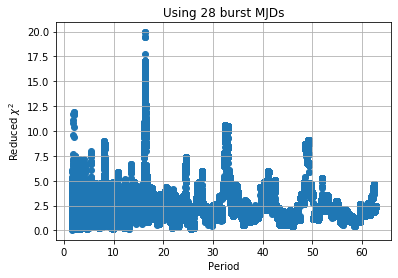

In [10]:
plt.scatter(p, rch)
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.xlabel('Period')
plt.grid()

#### Looks like there is a strong peak at 16.41 day period. 
#### Let's try just with the activity days now

In [11]:
rch_uniq, p = pr3_search(bursts=unique_days, obs_mjds=startmjds, 
                    obs_durations=durations)

100%|██████████| 250430/250430 [01:50<00:00, 2268.43it/s]
2020-06-08 14:04:29,557 - pr3_search -root - INFO - Max reduced chi square value is 52.08871631047803 at period of 4.982003601819278


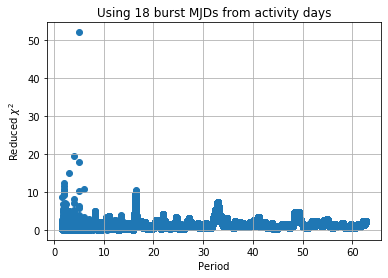

In [12]:
plt.scatter(p, rch_uniq)
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.xlabel('Period')
plt.grid()

#### The peak now seems to be at 4.98 days, which is a harmonic of the sidereal day, due to daily exposure of CHIME. But there is a peak at 16ish days as well! 

# Searching for period with narrowest folded profile (Rajwade et al 2020)
### Rajwade et al (2020) actually calls it searching for the largest continuous fraction in the folded profile without burst signal

In [13]:
bursts = np.sort(bursts - np.min(bursts))
unique_days = np.unique(np.round(bursts))

In [14]:
cont_frac, p = riptide_search(bursts, pmin=1, pmax=50)

2020-06-08 14:04:31,829 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods from 2.0003245962833724 days for search.
100%|██████████| 5071/5071 [00:03<00:00, 1325.28it/s]
2020-06-08 14:04:35,658 - riptide_search -root - INFO - Max continuous fraction without data is 0.725 at a period of 16.346153846153847 days


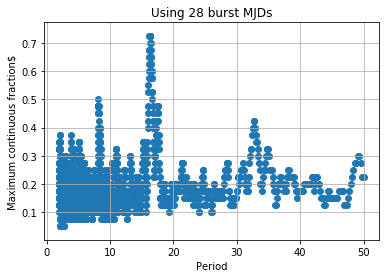

In [15]:
plt.scatter(p, cont_frac)
plt.ylabel(r'Maximum continuous fraction$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.xlabel('Period')
plt.grid()

In [16]:
cont_frac_uniq, p = riptide_search(unique_days, pmin=1, pmax=50)

2020-06-08 14:04:35,877 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods from 2.000146870688089 days for search.
100%|██████████| 5070/5070 [00:03<00:00, 1321.50it/s]
2020-06-08 14:04:39,717 - riptide_search -root - INFO - Max continuous fraction without data is 0.75 at a period of 16.292541636495294 days


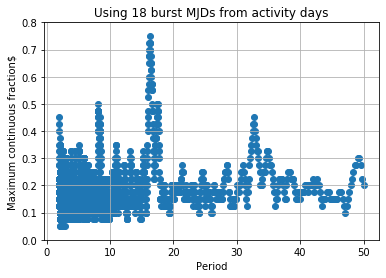

In [17]:
plt.scatter(p, cont_frac_uniq)
plt.ylabel(r'Maximum continuous fraction$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.xlabel('Period')
plt.grid()

#### Here, the strongest peaks are at periods consistent with PR3. 

# Using P4J
### using QMI based on Euclidean distance for periodogram. See https://github.com/phuijse/P4J

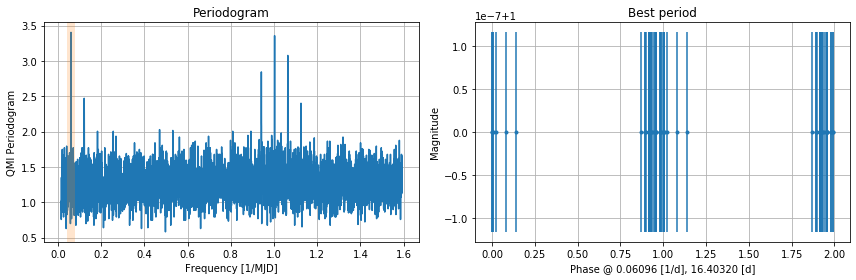

In [18]:
periodogram, p = p4j_search(bursts, pmin=np.pi*0.2, pmax=np.pi*20, plot=True, save=False, mjd_err=0.01)

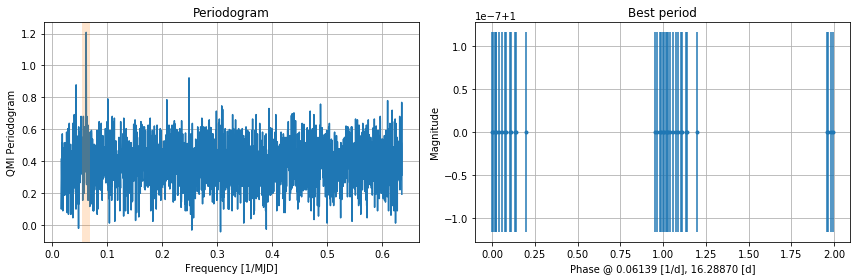

In [19]:
periodogram_unique, p = p4j_search(unique_days, pmin=np.pi*0.5, pmax=np.pi*20, plot=True, save=False, mjd_err=0.01)

#### Again, we can recover the period reported by PR3. 

### Method #2 (Rajwade et al 2020) and #3 (P4J) are two new tests which weren't used in PR3. So, recovery of the published periods using these methods improves the confidence in the period reported by PR3. 